<a href="https://colab.research.google.com/github/djps/k-wave-python/blob/modelling_in_3D/examples/at_focused_annular_array_3D/at_focused_annular_array.3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelling A Focused Annular Array Transducer In 3D Example

This example models a focused annular array transducer in 3D. The on-axis pressure is compared with the exact solution calculated using `focused_annulus_oneil`.

First, define the settings, import the libraries and functions needed

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from kwave.data import Vector
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.utils.filters import extract_amp_phase
from kwave.utils.mapgen import focused_annulus_oneil
from kwave.utils.math import round_even
from kwave.utils.kwave_array import kWaveArray
from kwave.utils.signals import create_cw_signals

from kwave.kspaceFirstOrder3D import kspaceFirstOrder3DC

from kwave.options.simulation_options import SimulationOptions
from kwave.options.simulation_execution_options import SimulationExecutionOptions

from kwave.utils.plot import voxel_plot

The parameters of the system are defined below.

In [ ]:
# medium parameters
c0: float            = 1500.0  # sound speed [m/s]
rho0: float          = 1000.0  # density [kg/m^3]

# source parameters
source_f0            = 4.0e6# source frequency [Hz]
source_roc           = 1.0e3# bowl radius of curvature [m]
source_amp           = np.ones(10)#np.array([0.5e6, 1e6, 0.75e6])           # source pressure [Pa]
source_phase = np.deg2rad(np.array([
    3.09, 4.54, 0.49, 2.54, 4.46,
    6.26, 1.68, 3.29, 4.82, 0.00  # 注意最后元素不需要逗号
]))  # 将角度值转换为弧度


# aperture diameters of the elements given an inner, outer pairs [m]
diameters = np.array([
    [0.0000,  5.5272],  
    [6.0522,  8.1963],  
    [8.7213, 10.3253],
    [10.8503, 12.1769],
    [12.7019, 13.8524],
    [14.3774, 15.4033],
    [15.9283, 16.8600],
    [17.3850, 18.2425],
    [18.7675, 19.5645],
    [20.0895, 20.8359]
]) * 1e-3

diameters       = diameters.tolist()

# grid parameters
axial_size: float    = 50.0e-3  # total grid size in the axial dimension [m]
lateral_size: float  = 30.0e-3  # total grid size in the lateral dimension [m]

# computational parameters
ppw: int             = 3      # number of points per wavelength
t_end: float         = 40e-6  # total compute time [s] (this must be long enough to reach steady state)
record_periods: int  = 1      # number of periods to record
cfl: float           = 0.5    # CFL number
source_x_offset: int = 20     # grid points to offset the source
bli_tolerance: float = 0.01   # tolerance for truncation of the off-grid source points
upsampling_rate: int = 10     # density of integration points relative to grid
verbose_level: int   = 0      # verbosity of k-wave executable

## Grid

Construct the grid via the `kgrid` class

In [64]:
# calculate the grid spacing based on the PPW and F0
dx: float = c0 / (ppw * source_f0)   # [m]

# compute the size of the grid
Nx: int = round_even(axial_size / dx) + source_x_offset
Ny: int = round_even(lateral_size / dx)
Nz: int = Ny

grid_size_points = Vector([Nx, Ny, Nz])
grid_spacing_meters = Vector([dx, dx, dx])

# create the k-space grid
kgrid = kWaveGrid(grid_size_points, grid_spacing_meters)

# compute points per period
ppp: int = round(ppw / cfl)

# compute corresponding time spacing
dt: float = 1.0 / (ppp * source_f0)

# create the time array using an integer number of points per period
Nt: int = int(np.round(t_end / dt))
kgrid.setTime(Nt, dt)

# calculate the actual CFL and PPW
print('points-per-period: ' + str(c0 / (dx * source_f0)) + ' and CFL number : ' + str(c0 * dt / dx))

points-per-period: 3.0 and CFL number : 0.5


## Source

Define the source, using the `kWaveArray` class and the `add_bowl_element` method along with a continuous wave signal.

In [65]:
# 创建声源对象
source = kSource()

# 生成连续波信号 (3个阵元不同幅相)
source_signal = create_cw_signals(
    np.squeeze(kgrid.t_array),  # 时间轴数据
    source_f0,                  # 4MHz 中心频率
    source_amp,                 # 各阵元幅度 [0.5,1.0,0.75] MPa
    source_phase                # 各阵元相位差 [0°,10°,20°]
)

# 初始化换能器阵列 (配置边界层插值参数)
karray = kWaveArray(
    bli_tolerance=bli_tolerance,    # 边界层插值容差 (0.01)
    upsampling_rate=upsampling_rate,  # 上采样率 (10倍)
    single_precision=True           # 单精度模式节省内存
)

# 设置碗状换能器几何参数
bowl_pos = [kgrid.x_vec[0].item() + source_x_offset * kgrid.dx, 0, 0]  # 换能器中心位置 (左侧偏移)
focus_pos = [kgrid.x_vec[-1].item(), 0, 0]  # 声学焦点位置 (右侧边界)

# 添加环形阵列元素 (3个同心圆环)
karray.add_annular_array(
    bowl_pos,        # 换能器中心坐标
    source_roc,      # 30mm 曲率半径
    diameters,       # 阵元内外径 [[0,5], [10,15], [20,25]] mm
    focus_pos        # 声波聚焦位置
)

# 生成声源空间分布掩模
source.p_mask = karray.get_array_binary_mask(kgrid)  # 三维布尔掩模

# 分配带相位差的声源信号
source.p = karray.get_distributed_source_signal(kgrid, source_signal)  # 时空分布信号


## Medium

The medium is water. Neither nonlinearity nor attenuation are considered.

In [66]:
# assign medium properties
medium = kWaveMedium(sound_speed=c0, density=rho0)

## Sensor

The sensor class defines what acoustic information is recorded.

In [67]:
sensor = kSensor()

# set sensor mask to record central plane, not including the source point
sensor.mask = np.zeros((Nx, Ny, Nz), dtype=bool)
sensor.mask[(source_x_offset + 1):, :, Nz // 2] = True

# record the pressure
sensor.record = ['p']

# record only the final few periods when the field is in steady state
sensor.record_start_index = kgrid.Nt - (record_periods * ppp) + 1

## Simulation

In [68]:
simulation_options = SimulationOptions(pml_auto=True,
                                       data_recast=True,
                                       save_to_disk=True,
                                       save_to_disk_exit=False,
                                       pml_inside=False)

execution_options = SimulationExecutionOptions(is_gpu_simulation=True,
                                               delete_data=False,
                                               verbose_level=0)

sensor_data = kspaceFirstOrder3DC(medium=deepcopy(medium),
                                 kgrid=deepcopy(kgrid),
                                 source=deepcopy(source),
                                 sensor=deepcopy(sensor),
                                 simulation_options=simulation_options,
                                 execution_options=execution_options)

d:\ProgramData\miniconda3\Lib\site-packages\kwave\options\simulation_execution_options.py:111: UserWarning: Custom binary name set. Ignoring `is_gpu_simulation` state.
  warnings.warn("Custom binary name set. Ignoring `is_gpu_simulation` state.")


+---------------------------------------------------------------+
|                   kspaceFirstOrder-OMP v1.3                   |
+---------------------------------------------------------------+
| Reading simulation configuration:                        Done |
| Number of CPU threads:                                     12 |
| Processor name:           12th Gen Intel(R) Core(TM) i5-12500 |
+---------------------------------------------------------------+
|                      Simulation details                       |
+---------------------------------------------------------------+
| Domain dimensions:                            486 x 288 x 288 |
| Medium type:                                               3D |
| Simulation time steps:                                    960 |
+---------------------------------------------------------------+
|                        Initialization                         |
+---------------------------------------------------------------+
| Memory a

## Post-processing

Extract amplitude from the sensor data, using the Fourier transform. The data can be reshaped to match the spatial extents of the domain. The on-axis pressure amplitudes found and axes for plotting defined.

In [69]:
# extract amplitude from the sensor data
amp, _, _  = extract_amp_phase(sensor_data['p'].T, 1.0 / kgrid.dt, source_f0, dim=1, fft_padding=1, window='Rectangular')

# reshape data
amp = np.reshape(amp, (Nx - (source_x_offset + 1), Ny), order='F')

# extract pressure on axis
amp_on_axis = amp[:, Ny // 2]

# define axis vectors for plotting
x_vec = np.squeeze(kgrid.x_vec[(source_x_offset + 1):, :] - kgrid.x_vec[source_x_offset])
y_vec = kgrid.y_vec

## Analytical Solution

An analytical expression cam be found in Pierce<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). Given a transdcuer of radius $a$, wavenumber $k= 2 \pi f / c$, where $f$ is the frequency, speed of sound $c$, and a unit normal vector to transducer surface, $\hat{v}_n$, the on-axis pressure is given by

$$
p_{\mathrm{ref}}(z) = −2 \, i \, \rho \, c \, \hat{v}_n \, e^{i k \left( z + \sqrt{z^2 + a^2} \right) \big/ 2} \sin \left( \dfrac{k}{2} \left( \sqrt{z^2 + a^2} − z \right) \right).
$$

<a name="cite_note-1"></a>[<sup>[1]</sup>](#cite_ref-1) A. D. Pierce, _"Acoustics: An Introduction to its Physical Principles and Applications"_ Springer (2019).

In [70]:
p_axial = focused_annulus_oneil(source_roc, np.asarray(diameters).T, source_amp / (c0 * rho0), source_phase, source_f0, c0, rho0, np.squeeze(x_vec))

## Visualisation

First plot the pressure along the focal axis of the piston

In [71]:
fig1, ax1 = plt.subplots(1, 1)
ax1.plot(1e3 * x_vec, 1e-6 * p_axial, 'k-', label='Analytical')
ax1.plot(1e3 * x_vec, 1e-6 * amp_on_axis, 'b.', label='k-Wave')
ax1.legend()
ax1.set(xlabel='Axial Position [mm]',
        ylabel='Pressure [MPa]',
        title='Axial Pressure')
ax1.set_xlim(0.0, 1e3 * axial_size)
ax1.set_ylim(0.0, 6)
ax1.grid()

Next plot the source mask (pml is outside the grid in this example). This means getting the grid weights first

In [72]:
# get grid weights
grid_weights = karray.get_array_grid_weights(kgrid)

fig2, (ax2a, ax2b) = plt.subplots(1, 2)
ax2a.pcolormesh(1e3 * np.squeeze(kgrid.y_vec),
                1e3 * np.squeeze(kgrid.x_vec),
                np.flip(source.p_mask[:, :, int(np.ceil(Nz / 2))], axis=0),
                shading='nearest')
ax2a.set(xlabel='y [mm]',
         ylabel='x [mm]',
         title='Source Mask')
ax2b.pcolormesh(1e3 * np.squeeze(kgrid.y_vec),
                1e3 * np.squeeze(kgrid.x_vec),
                np.flip(grid_weights[:, :, int(np.ceil(Nz / 2))], axis=0),
                shading='nearest')
ax2b.set_xlabel('y [mm]')
ax2b.set_ylabel('x [mm]')
_ = ax2b.set_title('Off-Grid Source Weights')
plt.tight_layout(pad=1.2)

Finally, plot the pressure field

In [73]:
fig3, ax3 = plt.subplots(1, 1)
p3 = ax3.pcolormesh(1e3 * np.squeeze(y_vec),
                    1e3 * np.squeeze(x_vec),
                    np.flip(amp, axis=1) / 1e6,
                    shading='gouraud')
ax3.set(xlabel='Lateral Position [mm]',
        ylabel='Axial Position [mm]',
        title='Pressure Field')
ax3.set_ylim(1e3 * x_vec[-1],  1e3 * x_vec[0])
cbar3 = fig3.colorbar(p3, ax=ax3)
_ = cbar3.ax.set_title('[MPa]', fontsize='small')

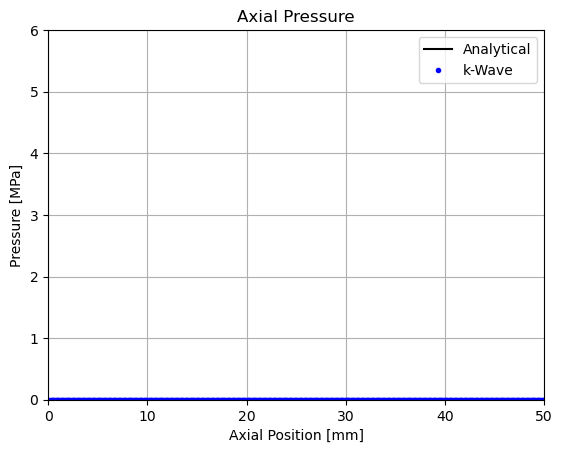

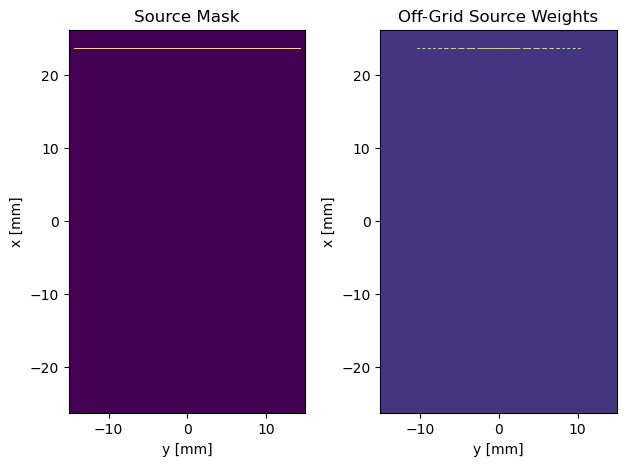

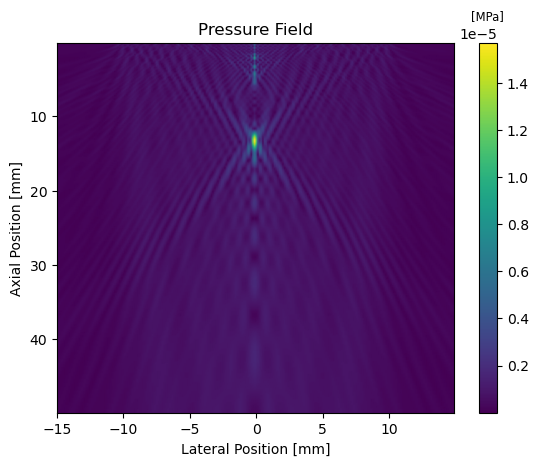

In [74]:
plt.show()